<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Fruits_unsupervised_clustering_conv2_12August_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import torch.nn as nn
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 
import matplotlib.image as mpimg
import torchvision

In [64]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
#!unzip '/content/drive/My Drive/AutoEncoder_training.zip' -d '/content/drive/My Drive/AutoEncoder_training' 

In [66]:
#!unzip /content/Fruits.zip -d /content/

In [67]:
#Data_path = "/content/Fruits/"
Data_path = "/content/drive/My Drive/AutoEncoder_training/AutoEncoder_training/"

In [68]:
#filelist = glob.glob(Data_path+'/*.jfif')
filelist = glob.glob(Data_path+'/*.tiff')

In [69]:
filelist[2]

'/content/drive/My Drive/AutoEncoder_training/AutoEncoder_training/Defect_11285_Class_1_Multi.tiff'

In [70]:
len(filelist)

90

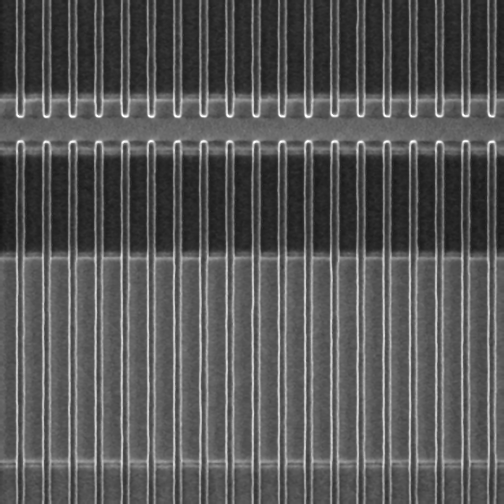

In [71]:
from PIL import Image

Image.open(filelist[88])

(504, 504)


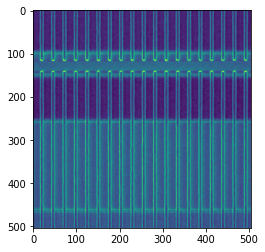

In [72]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(filelist[88])
print(img.shape)
plt.imshow(img)


Original Dimensions :  (504, 504, 3)


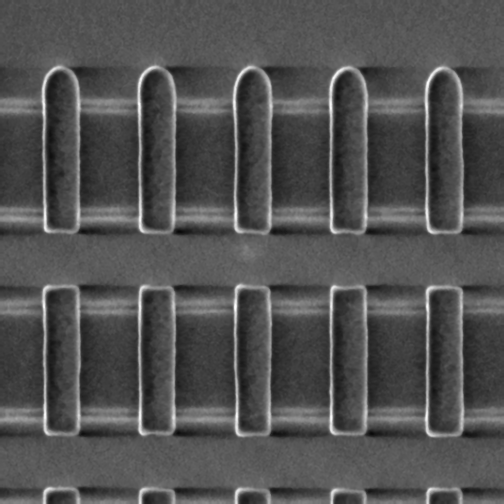

Resized Dimensions :  (504, 504, 3)


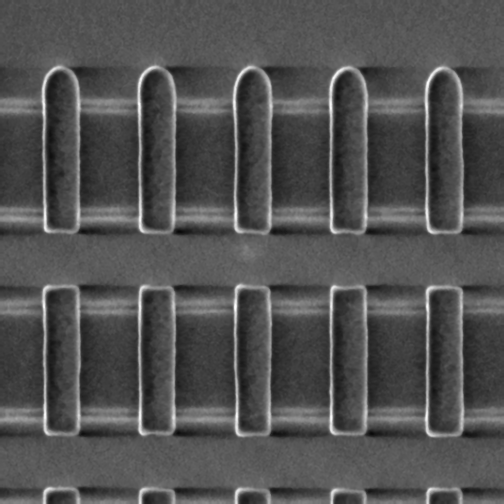

In [73]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filelist[9])
print('Original Dimensions : ',img.shape)
cv2_imshow(img)
dim = (504,504)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)
cv2_imshow(resized)


Lets Resize all images to same size

In [74]:
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 226):
    #self.filelist = glob.glob(path+'/*.jfif')
    self.filelist = glob.glob(path+'/*.tiff')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    temp_filepath = self.filelist[idx]
    temp_image = cv2.imread(temp_filepath)
    #print(temp_image)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #dim = (504,504)
    #temp_image = cv2.resize(temp_image, dim, interpolation = cv2.INTER_AREA)
    #print('Resized Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #print(temp_image.shape)
    temp_image = temp_image/255
    #plt.imshow(temp_image,cmap='gray',vmin=0,vmax=1)
    #temp_image = torch.from_numpy(temp_image)
    temp_image = torch.Tensor(temp_image)
    #print(temp_image.shape)
    #print(temp_image)
    temp_image = temp_image.unsqueeze(0)
    #print(temp_image.shape)
    return temp_image

In [75]:
Data = CustomDataset(Data_path)
Data[2].shape

torch.Size([1, 504, 504])

In [87]:
latent_dim = 128

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.enc1 = nn.Conv2d(1,32,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(32,64,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(64,128,kernel_size=2,stride=3)
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        self.FC1 = nn.Linear(3200,1024)
        self.FC2 = nn.Linear(1024,latent_dim)

    def forward(self,x):
        x = F.relu(self.enc1(x)) # output will be 168x168x32
        x,indices1 = self.pool(x) #output will be 84x84x32
        x = F.relu(self.enc2(x)) #output will be 28x28x64
        x,indices2 = self.pool(x)   # output will be 14x14x64
        x = F.relu(self.enc3(x)) #output will be 5x5x128 
        x = x.view(-1,3200) # after flattening the size will be 3200
        x = F.relu(self.FC1(x))
        x = F.relu(self.FC2(x)) # the latent space representation
        return x,indices1,indices2
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.FC3 = nn.Linear(latent_dim,1024)
        self.FC4 = nn.Linear(1024,3200)
        self.dec1 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=3)  
        self.dec2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(32,1, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2,padding=0)
        
        
    def forward(self,x,indices1,indices2):
        x = F.relu(self.FC3(x)) #size back to 3200
        x = F.relu(self.FC4(x))
        x = torch.reshape(x,(1,128,5,5))
        x = F.relu(self.dec1(x)) # ouput will be 14x14x64
        x = self.unpool(x,indices2) #output will be 28x28x64
        x = F.relu(self.dec2(x)) # output will be 84x84x32
        x = self.unpool(x,indices1) #output will be 168x168x32
        #x = self.dec3(x) # output will be 504x504x1
        x = torch.sigmoid(self.dec3(x)) # output will be 504x504x1
        return x
    
class Conv2d_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv2d_AutoEncoder, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        
        z,indices1,indices2 = self.enc(x)
        
        out = self.dec(z,indices1,indices2)
        
        return out

**Lets write the first Auto encoder **

In [88]:
class Conv2d_Autoencoder(nn.Module):
    def __init__(self):
        super(Conv2d_Autoencoder, self).__init__()
        latent_dim = 1024
 
        # encoder layers
        self.enc1 = nn.Conv2d(1,64,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(64,128,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(128,256,kernel_size=2,stride=3)
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        self.FC1 = nn.Linear(6400,latent_dim)
        
        # decoder layers
        self.FC2 = nn.Linear(latent_dim,6400)
        self.dec1 = nn.ConvTranspose2d(256,128, kernel_size=2, stride=3)  
        self.dec2 = nn.ConvTranspose2d(128,64, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(64,1, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2,padding=0)

 
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x)) # output will be 168x168x64
        x,indices1 = self.pool(x) #output will be 84x84x64
        x = F.relu(self.enc2(x)) #output will be 28x28x128
        x,indices2 = self.pool(x)   # output will be 14x14x128
        x = F.relu(self.enc3(x)) #output will be 5x5x256 
        x = x.view(-1,6400) # after flattening the size will be 3200
        x = F.relu(self.FC1(x)) # the latent space representation
  
        # decode
        x = F.relu(self.FC2(x)) #size back to 3200
        x = torch.reshape(x,(1,256,5,5))
        x = F.relu(self.dec1(x)) # ouput will be 14x14x128
        x = self.unpool(x,indices2) #output will be 28x28x128
        x = F.relu(self.dec2(x)) # output will be 84x84x64
        x = self.unpool(x,indices1) #output will be 168x168x64
        #x = self.dec3(x) # output will be 504x504x1
        x = torch.sigmoid(self.dec3(x)) # output will be 504x504x1
        return x
 

In [89]:
net = Conv2d_AutoEncoder()
print(net)
#summary(net,(1,504,504))

Conv2d_AutoEncoder(
  (enc): Encoder(
    (enc1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3))
    (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    (enc3): Conv2d(64, 128, kernel_size=(2, 2), stride=(3, 3))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (FC1): Linear(in_features=3200, out_features=1024, bias=True)
    (FC2): Linear(in_features=1024, out_features=128, bias=True)
  )
  (dec): Decoder(
    (FC3): Linear(in_features=128, out_features=1024, bias=True)
    (FC4): Linear(in_features=1024, out_features=3200, bias=True)
    (dec1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(3, 3))
    (dec2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
    (dec3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(3, 3))
    (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
)


In [90]:
train_loader = DataLoader(Data,batch_size=1)

In [91]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 


In [94]:
from tqdm.notebook import tqdm
n_epochs = 100

if torch.cuda.is_available():
    net.cuda()
total_loss = []

epoch_loss = 0
net.train()
for epoch in tqdm(range(n_epochs)):
    print("current epoch is:",epoch)
    epoch_loss = 0
    for x in train_loader:
        mse_loss = 0
        if torch.cuda.is_available():
            x = x.cuda()
            #print(x.shape)
        optimizer.zero_grad()
        prediction = net(x)
        mse_loss = loss_func(prediction, x) # <-- note that i'm using the input as the target
        epoch_loss = epoch_loss + mse_loss.item()
        mse_loss.backward()
        optimizer.step()
        
    #clear_output(wait=True)
    total_loss.append(epoch_loss)
    print('Loss Per epoch: ',epoch_loss)

import matplotlib.pyplot as plt
plt.plot(total_loss)

current epoch is: 0


KeyboardInterrupt: ignored

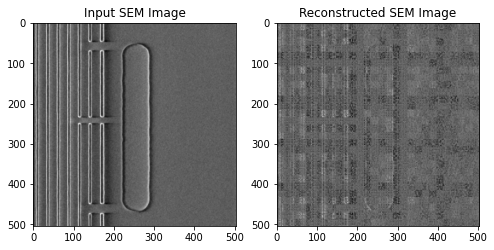

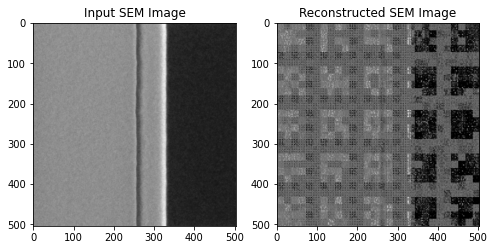

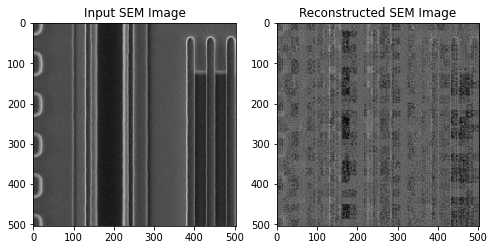

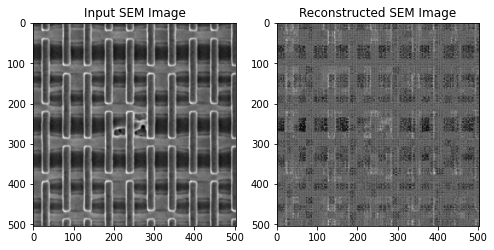

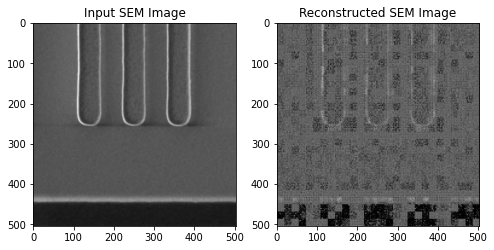

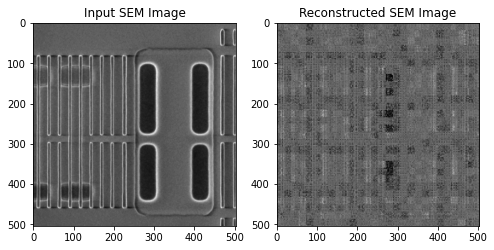

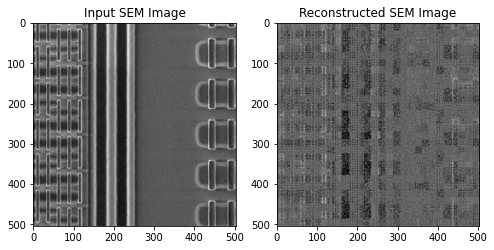

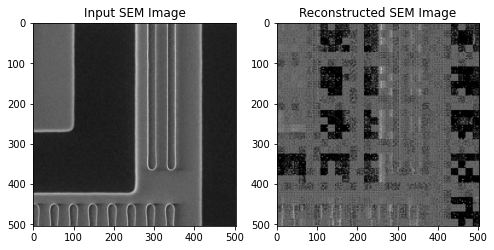

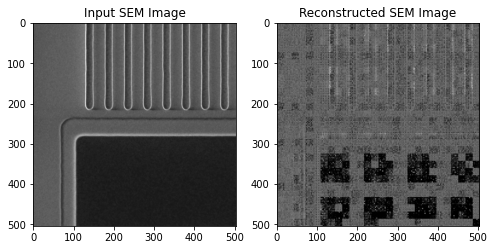

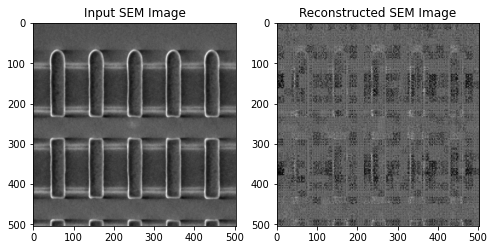

In [82]:
import matplotlib.pyplot as plt

net.cpu()
net.eval()
counter = 0
for i in range(10):
    counter = counter + 1
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    x = Data[i]
    input_img = x[0]
    #print(input_img)
    model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]
    #print(model_pred)
    ax[0].set_title('Input SEM Image',fontsize=12)
    ax[1].set_title('Reconstructed SEM Image',fontsize=12)
    ax[0].imshow(input_img,cmap='gray',vmin=0,vmax=1)
    ax[1].imshow(model_pred,cmap='gray',vmin=0,vmax=1)


In [83]:
net.enc2.weight.shape

ModuleAttributeError: ignored